In [1]:
using Pipe
using DataFrames
# using StatsPlots
using CSV
# using RollingFunctions
using Query
# using GLMakie

using JSON
using DataFrames
using Dates
using Colors
# using ColorSchemes
using Indicators

import Colors
using Plots
using Interact
using Statistics
using StatsBase

include("utils.jl")

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-4686462730788379912\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-4308869989634352710\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-4686462730788379912\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

calc_wavelet (generic function with 1 method)

In [2]:
function rjsonf(fname)
    f = open(fname, "r")
    json_data = JSON.parse(f)
    close(f)
    json_data
end
function wjsonf(fname,obj)
    open(fname,"w") do io
       println(io,JSON.json(obj))
    end
end

wjsonf (generic function with 1 method)

In [3]:
DateTime(0)

0000-01-01T00:00:00

In [4]:
function loadOHLC(;fname="BTC_USDT-1m.json", start_date = DateTime(2021, 1, 1), end_date = DateTime(2021, 6, 12))
    json_data_folder = "../user_data/data/binance"
    json_filename = "BTC_USDT-1m.json"
    json_filepath = "$json_data_folder/$json_filename"
    json_data = rjsonf(json_filepath)

    dfa = DataFrame(unix_time = Int64[], open=Float64[], high=Float64[], low=Float64[], close=Float64[], volume=Float64[])
    for r in json_data push!(dfa, r) end
    dfa.unix_time .= dfa.unix_time ./1000
    # dfa.time .= unix2datetime.(dfa.unix_time)
    insertcols!(dfa, :time => unix2datetime.(dfa.unix_time))
    vdf = dfa[(dfa.time .>= start_date) .& (dfa.time .<= end_date) , :]
end

loadOHLC (generic function with 1 method)

60481

In [6]:
function backtest(vdf::DataFrame, p::Dict; shouldEnter = (args...) -> false, getEntry = (args...) -> (0,0), shouldExit = (args...) -> (false, 0))
#     capital = 10000.
#     qfee = 0.001
#     risk_percent = 0.01
    dfo=DataFrame(ut = 0, tt=DateTime(0), oix =0, order = :init, reason = :init, price = 0., stop = 0., target=0.,
                qty = 0., pnl = 0., capital = 10000.)
    
    capital = p[:capital]
    in_pos = false 
    for i in p[:interval]

        ord = last(dfo)
        if !in_pos
            should_enter, order_type = shouldEnter(p, i, ord)
            if should_enter
                (enter_price, stop_price, target_price, qty) = getEntry(order_type, p, i)
#                 order_type = qty > 0 ? (:long) : short ;
                enter_price_with_fee = enter_price*(1+qfee)
                push!(dfo, (ut = vdf.unix_time[i], tt=vdf.time[i], oix=i, order = order_type, reason = :enter, price = enter_price_with_fee, qty = qty,
                        stop = stop_price, target=target_price, pnl = 0, capital = capital))

                in_pos = true
            end
        else
            (do_exit, exit_price) = shouldExit(p, i, ord)
            if do_exit
                profit_loss = ord.qty * (exit_price - ord.price)
                capital = capital + profit_loss

                push!(dfo, (ut = vdf.unix_time[i], tt=vdf.time[i], oix=i, order = :long, reason = :exit, price = exit_price, stop = 0, target=0,
                         qty = ord.qty, pnl = profit_loss, capital = capital))

                in_pos = false
            end
        end
    end
    CSV.write("trades.csv", dfo)
#     p[:dfo]
    dfo
end

backtest (generic function with 1 method)

In [7]:

# params

In [90]:
vdf = loadOHLC(fname="BTC_USDT-1m.json", start_date = DateTime(2021, 6, 1), end_date = DateTime(2021, 6, 12))
# first(vdf), last(vdf)
nrow(vdf)

60481

In [91]:
arlen = nrow(vdf) 
wsl = window_slider(arlen, subs=3); 
rng = Interact.@map &wsl

plot_box = Observable{Any}(dom"div"())
res_box = Observable{Any}(dom"div"())

# tplagHsl = slider(0:5:600; label="tplagHsl", default=14); tplagHsl[] = 30;
# tplagHs = Interact.@map  [fill(hh[1], &tplagHsl)..., [maximum(hh[i-&tplagHsl:i]) for i in &tplagHsl+1:arlen]...]

slCoolOff = slider(0:5:600; label="cool", default=30); slCoolOff[]=30;
# tracksl = slider(0:5:600; label="track", default=30); tracksl[]=30;

slStopLoss = slider(0:0.05:10; label="stop", default=14); slStopLoss[] = 2;
slTarget = slider(0:0.2:10; label="tgt", default=14); slTarget[] = 1;

slKama1N = slider(0:10:400; label="K1N", default=50); slKama1N[] = 10;
slKama1Fast = slider(0:0.02:1; label="K1F", default=0.6); slKama1Fast[] = 0.6667; 
slKama1Slow = slider(0:0.02:1; label="K1S", default=0.0645); slKama1Slow[] = 0.0645;
slKama1Channel= slider(0:0.05:5; label="K1CH", default=0); 

iKama1 = Interact.@map kama(vdf.close, n=&slKama1N, nfast=&slKama1Fast, nslow=&slKama1Slow)
iKama1ChannelL = Interact.@map &iKama1 * (1-&slKama1Channel/100) 
dfoa = Observable{DataFrame}(DataFrame(ut = 0, tt=DateTime(0), oix =0, order = :long, reason = :init, price = 0, stop = 0, target=0,
                qty = 0, pnl = 0, capital = 10000));
# dfoa = []

function get_results(dfo)
    buys = filter(row -> row.reason == :enter, dfo)
    losses = filter(row -> row.reason == :exit && row.pnl < 0, dfo)
    profits = filter(row -> row.reason == :exit && row.pnl > 0, dfo)
    no_losses = nrow(losses)
    no_profits = nrow(profits)
    tot_losses = Int(trunc(sum((losses).pnl)))
    tot_profits = Int(trunc(sum((profits).pnl)))
    (buys,losses,profits,no_losses,no_profits,tot_losses,tot_profits)
end

dff = dateformat"mm-dd"
dfft = dateformat"mm-dd HH:MM"
function draw_it_all(rng, iKama1, iKamaChannelL, dfo)
    wut = vdf.unix_time[rng]
    wtt = vdf.time[rng]
    if length(wut) == 0 return dom"div"( "Loading..." )end
    if nrow(dfo) == 0 return dom"div"( "Loading..." )end
    wst = first(rng); wed = last(rng)
    
    (buys,losses,profits,no_losses,no_profits,tot_losses,tot_profits) = get_results(dfo)
    wdfo = filter(row -> (row.ut >= first(wut) && row.ut <= last(wut)), dfo, view=false)
    (wbuys,wlosses,wprofits,wno_losses,wno_profits,wtot_losses,wtot_profits) = get_results(wdfo)
    
    
    
    f2 = plot(wut, vdf.close[rng])
    plot!(wut, vdf.low[rng], lw=0.5)
    plot!(wut, iKama1[rng], lw=0.5)
    plot!(wut, iKamaChannelL[rng], fillrange=iKama1[rng], lw=0, fillalpha=0.2)
    
    if nrow(wbuys) > 0  vline!(wbuys.ut,lw=0.5, color=:blue); scatter!(wbuys.ut, wbuys.price, markersize=2, color=:blue) end
    if nrow(wprofits) > 0 vline!(wprofits.ut,lw=0.5, color=:green); scatter!(wprofits.ut, wprofits.price, markersize=2, color=:green) end
    if nrow(wlosses) > 0 vline!(wlosses.ut,lw=0.5, color=:red); scatter!(wlosses.ut, wlosses.price, markersize=2, color=:red) end

    p2 = plot(dfo.capital)
#     vline!([wst,wed])
    wp2 = plot(wdfo.capital)
    
    l = @layout [
    a{0.7w} [grid(2,1)
    #              b{0.2h}  
                ]
    ]
    pm = plot(
       f2,wp2, p2,
        layout = l, size=(1500,400),legend=false        
    )
    
    dom"div"( 
            dom"div"(
                (
                    "$(Dates.format(first(vdf.time),dff))/$(Dates.format(last(vdf.time),dff))",
                    "$no_losses/$no_profits  $tot_losses/$tot_profits    $(tot_profits+tot_losses)",
                )
            ),
            dom"div"(
                (
                    "$(Dates.format(first(wtt),dfft))/$(Dates.format(last(wtt),dfft))",
                    "$wno_losses/$wno_profits  $wtot_losses/$wtot_profits    $(wtot_profits+wtot_losses)"
                )
            ),
    pm) 
end

ui = dom"div"(
        hbox(slStopLoss,slTarget,slCoolOff),
        hbox(slKama1N,slKama1Fast,slKama1Slow, slKama1Channel),
        plot_box,wsl
    )

dfoi = Interact.@map backtest(vdf, merge(params, Dict(
            :qfee => 0.001,
            :interval => 600:length(vdf.close),
            :capital => 10000,
            :iKama1ChannelL => &iKama1ChannelL,
            :slStopLoss => &slStopLoss,
            :slCoolOff => &slCoolOff,
            :slTarget => &slTarget
        )), 
        shouldEnter=shouldEnter, getEntry=getEntry, shouldExit=shouldExit); 
connect!(dfoi, dfoa)


# wsl[:log2_slider][] = 12
map!(draw_it_all, plot_box, rng, iKama1, iKama1ChannelL, dfoa)
ui




(div
  (div { style=Dict("display" => "flex", "flex-direction" => "row") }
    Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["stop"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 201, :default => 14, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :min => 1, :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Any} with 2 listeners. Value:
41, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/Users/johnsmith/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/all.js"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/InteractBase/Zfu5P/src/../assets/style.css"), Asset("css", nothing, "/Users/johnsmith/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000118ffd330, Task (runnable) @0x0000000118ffd330), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"0.0\",\"0.05\",\"0.1\",\"0.15\",\"0.2\",\"0.25\",\"0.3\",\"0.35\",\"0.4\",\"0.45\",\"0.5\",\"0.55\",\"0.6\",\"0.65\",\"0.7\",\"0.75\",\"0.8\",\"0.85\",\"0.9\",\"0.95\",\"1.0\",\"1.05\",\"1.1\",\"1.15\

In [92]:
params = rjsonf("params.json")
# eval(Meta.parse(reduce(*, ["params[\"interactive\"][\"$key\"]=$key[];" for (key, value) in params["interactive"]])));wjsonf("params.json",params)

eval(Meta.parse(reduce(*, ["$key[]=$value;" for (key, value) in rjsonf("params.json")["interactive"] ])))


230

In [23]:
params = rjsonf("params.json")
pari = params["interactive"]
# params["test"] = 666
# wjsonf("params.json",params)
# params

iKama1 = kama(vdf.close, n=pari["slKama1N"], nfast=pari["slKama1Fast"], nslow=pari["slKama1Slow"])
iKama1ChannelL = iKama1 * (1-pari["slKama1Channel"]/100) 

qfee = 0.001
capital = 10000
risk_per_trade = 0.01

function getEntrySize(capital, risk_per_trade, enter_price, stop_price)
    risk_size = capital * risk_per_trade
    risk_price_range = (enter_price - stop_price)
    qty = risk_size / risk_price_range
end
shouldEnter = ((p,i,ord) -> (!(ord.pnl < 0 && i - ord.oix < p[:slCoolOff] ) && vdf.close[i] < p[:iKama1ChannelL][i]) ?
    (true,:long) :
    (false, :none)
);

shouldExit = (p, i, ord) -> (
            ord.qty > 0 ? (
                vdf.high[i] >= ord.target ? (true, ord.target*(1-p[:qfee])) :
                vdf.low[i] <= ord.stop ? (true, ord.stop*(1-p[:qfee]) ) : 
                (false, 0)                
            ) : 
                (false, 0)
            );

getEntry = (order_type, p, i) -> begin 
    enter_price, stop_price, target_price = (vdf.close[i], vdf.close[i] * (1 - p[:slStopLoss]/100), vdf.close[i] * (1+ p[:slTarget]/100))
    qty = getEntrySize(capital, risk_per_trade, enter_price, stop_price)
    return ( enter_price, stop_price, target_price, qty)
end
p = merge(params, Dict(
            :qfee => 0.001,
            :interval => 600:length(vdf.close),
            :capital => 10000,
            :iKama1ChannelL => iKama1ChannelL
        ));
# dfo = backtest(vdf, p ,
#         shouldEnter = shouldEnter,    
#         getEntry = getEntry,
#         shouldExit = shouldExit
#     )
1

1

In [11]:
params = rjsonf("params.json")
for (key, value) in params["interactive"]
#     println("$key[]=$value")
#     eval()
end



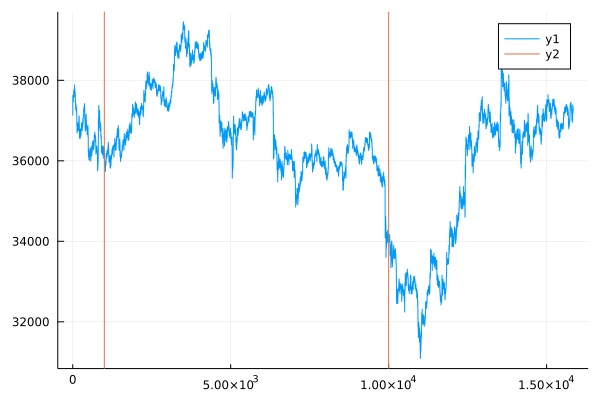

In [67]:

# plot(
#     [vdf.close, ema(vdf.close, n=500) , ema(vdf.close, n=1500)] ,
#     layout = l, legend = false, #seriestype = [:bar :scatter :path],
#     title = ["($i)" for j in 1:1, i in 1:11] #, titleloc = :right, titlefont = font(8)
# )
p1 = plot(vdf.close)
vline!([100010000])
# p2 = plot(ema(vdf.close, n=500))
# p3 = plot(ema(vdf.close, n=1500))


In [12]:
# 2^13 /60/24

In [13]:
# log2(60*24*7)

In [14]:
# plot(dfoi[].ut,dfoi[].capital,legend=false)

In [15]:
# dfoi